In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [63]:
train_path = "/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
test_path = "/kaggle/input/house-prices-advanced-regression-techniques/test.csv"

In [64]:
data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

train_data = data.drop(['SalePrice'], axis='columns')
price = pd.DataFrame({'SalePrice':data['SalePrice']})

In [88]:
train_data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
1         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
2         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
3         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
4         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      2    2008        WD         Normal  
1       0      5    2007        WD         Normal  
2       0      9    2008        WD         Normal  
3       0      2    2006        WD        Abnorml  
4       0     12    2008        WD         Normal  

[5 rows x 80 columns]

In [66]:
price.head()

SalePrice
0     208500
1     181500
2     223500
3     140000
4     250000

In [67]:
num_feat = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
            '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
            'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
            'ScreenPorch', 'PoolArea']

cat_feat = list(set(train_data.columns) - set(num_feat) - set(['Id', 'Utilities']))

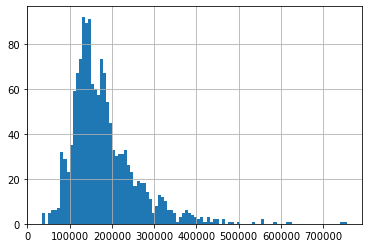

In [68]:
price['SalePrice'].hist(bins=100)

In [69]:
price['LogSalePrice'] = price.SalePrice.apply(np.log)
data['LogSalePrice'] = data.SalePrice.apply(np.log)

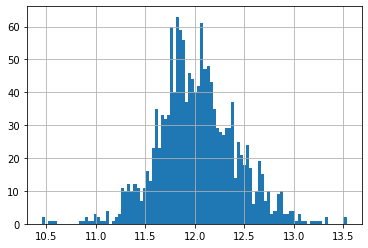

In [70]:
price['LogSalePrice'].hist(bins=100)

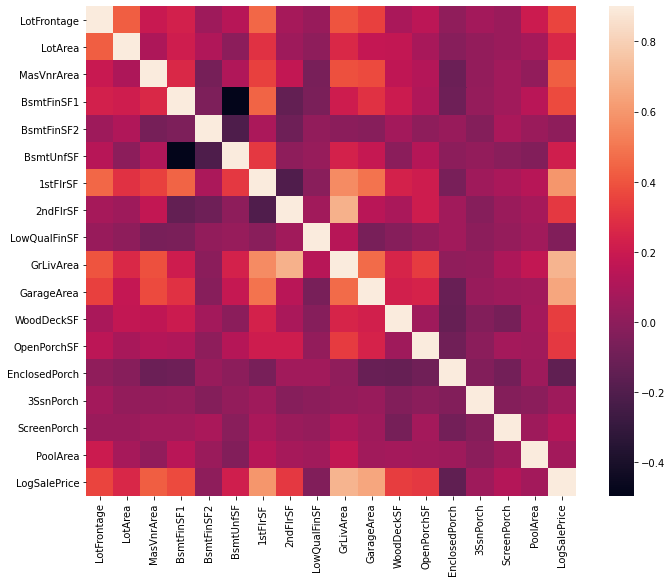

In [71]:
corrmat = data[num_feat + ['LogSalePrice']].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [72]:
cor = abs(corrmat['LogSalePrice']).sort_values()
cor

BsmtFinSF2       0.004832
LowQualFinSF     0.037963
3SsnPorch        0.054900
PoolArea         0.069798
ScreenPorch      0.121208
EnclosedPorch    0.149050
BsmtUnfSF        0.221985
LotArea          0.257320
2ndFlrSF         0.319300
OpenPorchSF      0.321053
WoodDeckSF       0.334135
LotFrontage      0.355878
BsmtFinSF1       0.372023
MasVnrArea       0.430809
1stFlrSF         0.596981
GarageArea       0.650888
GrLivArea        0.700927
LogSalePrice     1.000000
Name: LogSalePrice, dtype: float64

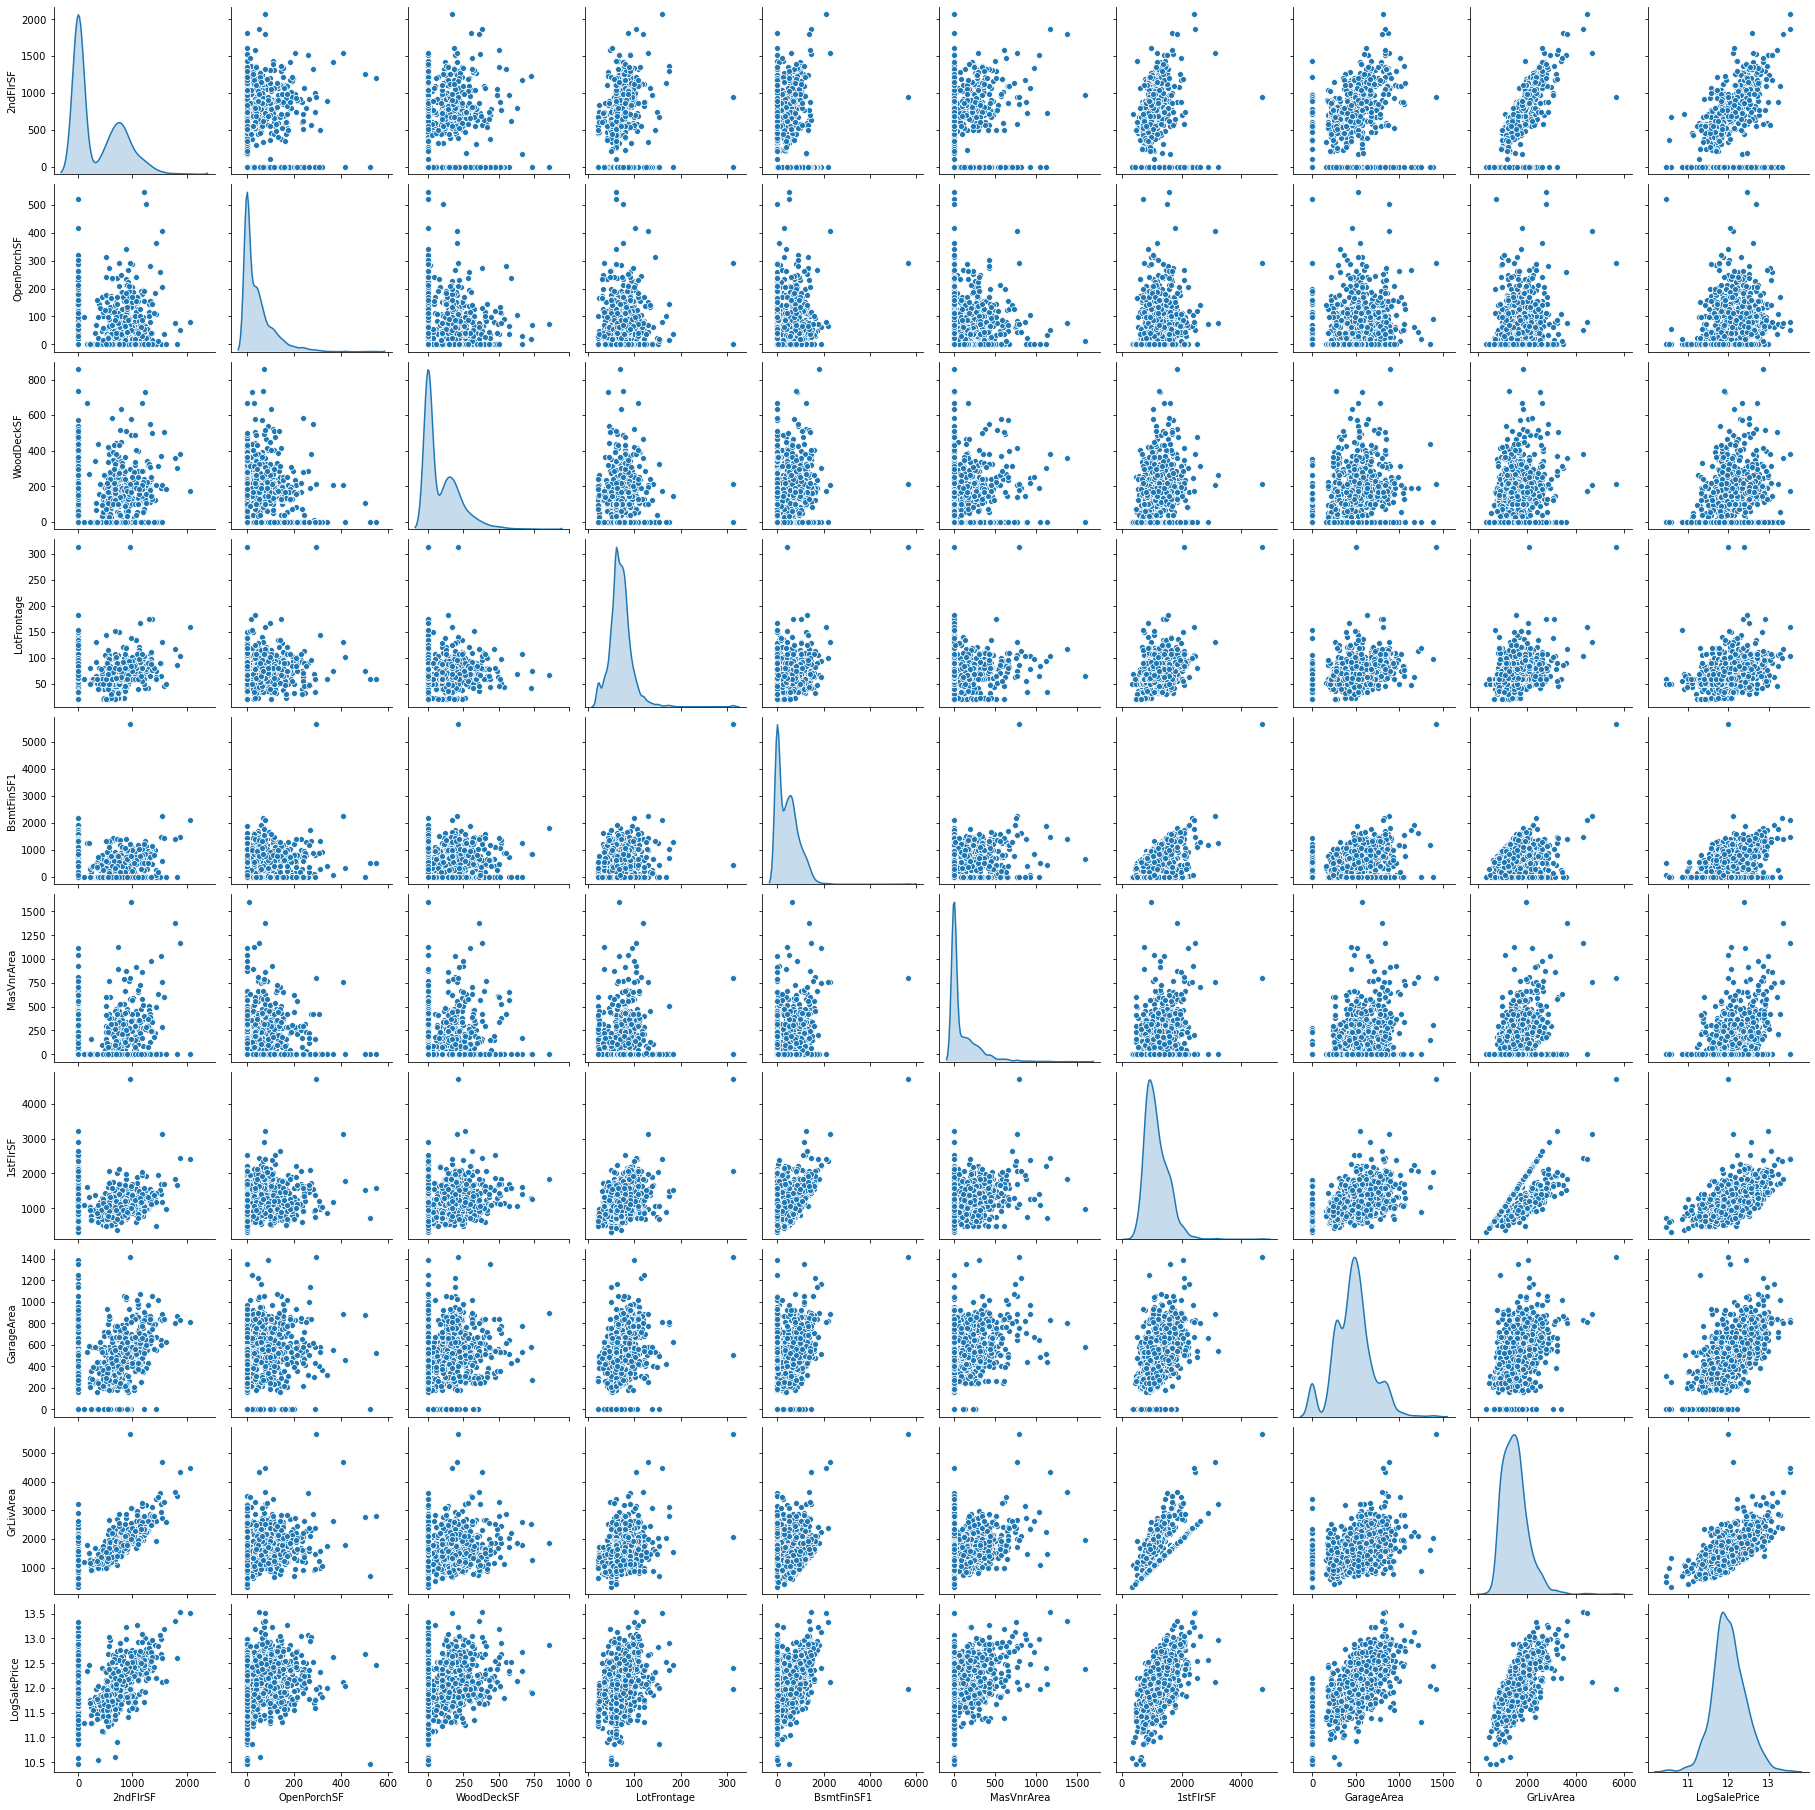

In [73]:
sns.pairplot(data[list(cor.index[-10:])], diag_kind="kde")
plt.show()

In [74]:
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)

In [75]:
feat_na = []
nan = []
for feat in list(all_data.columns):
    if all_data[feat].isna().sum() != 0:
        feat_na.append(feat)
        nan.append((all_data[feat].isna().sum()/len(all_data))*100)
nans = pd.DataFrame({'nan_percent': nan}, index=feat_na).sort_values(by='nan_percent', ascending=False)

In [76]:
nans[:15]

nan_percent
PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
FireplaceQu     48.646797
LotFrontage     16.649538
GarageFinish     5.447071
GarageQual       5.447071
GarageCond       5.447071
GarageYrBlt      5.447071
GarageType       5.378554
BsmtExposure     2.809181
BsmtCond         2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665

In [77]:
nans.index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageType',
       'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
       'MasVnrType', 'MasVnrArea', 'MSZoning', 'BsmtFullBath', 'BsmtHalfBath',
       'Functional', 'Utilities', 'GarageArea', 'GarageCars', 'Electrical',
       'KitchenQual', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1',
       'Exterior2nd', 'Exterior1st', 'SaleType'],
      dtype='object')

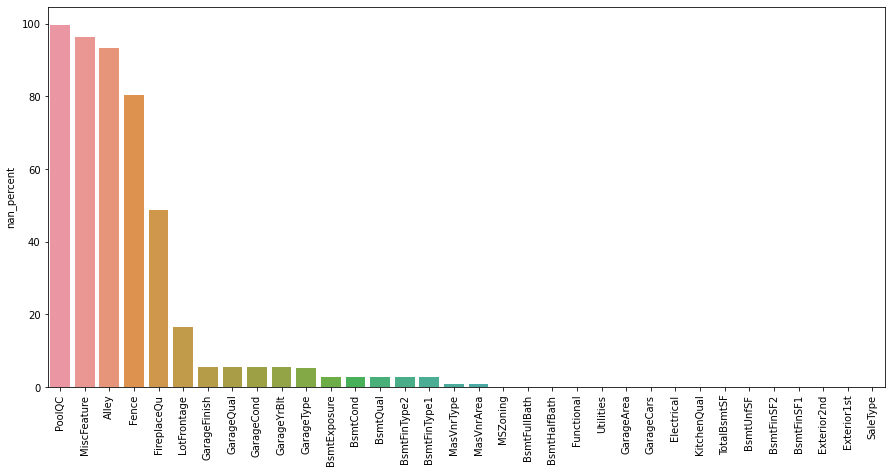

In [78]:
f, ax = plt.subplots(figsize=(15, 7))
plt.xticks(rotation='90')
sns.barplot(x=nans.index, y=nans['nan_percent'])

In [79]:
true_nan_feat = ['PoolQC', 'Alley', 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                 'GarageFinish', 'GarageType', 'GarageQual', 'GarageCond', 'Fence', 'MiscFeature']

for f in true_nan_feat:
    all_data[f] = all_data[f].fillna('None')

In [80]:
all_data['Alley'].value_counts()
#all_data['LotFrontage'] = all_data['LotFrontage'].fillna(np.mean(all_data['LotFrontage']))
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna('RL')
all_data['BsmtFullBath'] = all_data['BsmtFullBath'].fillna(0)
all_data['BsmtHalfBath'] = all_data['BsmtHalfBath'].fillna(0)
all_data['Functional'] = all_data['Functional'].fillna('Typ')
all_data = all_data.drop(['Utilities'], axis=1)
all_data = all_data.drop(['Id'], axis=1)
all_data['GarageArea'] = all_data['GarageArea'].fillna(0)
all_data['GarageCars'] = all_data['GarageCars'].fillna(0)
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].fillna(0)
all_data['BsmtFinSF2'] = all_data['BsmtFinSF2'].fillna(0)
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].fillna(0)
all_data['HalfBath'] = all_data['HalfBath'].fillna(0)
all_data['Exterior1st'] = all_data['Exterior1st'].fillna('VinylSd')
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna('VinylSd')
all_data['SaleType'] = all_data['SaleType'].fillna('WD')
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['GreenArea'] = all_data['LotArea'] - all_data['GrLivArea'] - all_data['GarageArea']

num_feat.append('TotalSF')
num_feat.append('GreenArea')

In [81]:
for f in cat_feat:
    all_data[f] = all_data[f].apply(str)

In [82]:
scaler = StandardScaler()
all_data[num_feat] = scaler.fit_transform(all_data[num_feat])

In [83]:
all_data

MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0            60       RL    -0.209359 -0.217879   Pave  None      Reg   
1            20       RL     0.481900 -0.072044   Pave  None      Reg   
2            60       RL    -0.071107  0.137197   Pave  None      IR1   
3            70       RL    -0.439779 -0.078385   Pave  None      IR1   
4            60       RL     0.666236  0.518903   Pave  None      IR1   
...         ...      ...          ...       ...    ...   ...      ...   
2914        160       RM    -2.237052 -1.043937   Pave  None      Reg   
2915        160       RM    -2.237052 -1.049263   Pave  None      Reg   
2916         20       RL     4.168614  1.246808   Pave  None      Reg   
2917         85       RL    -0.347611  0.034605   Pave  None      Reg   
2918         60       RL     0.205396 -0.068620   Pave  None      Reg   

     LandContour LotConfig LandSlope  ... PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    Inside       Gtl  ...   None   None        None       0   
1            Lvl       FR2       Gtl  ...   None   None        None       0   
2            Lvl    Inside       Gtl  ...   None   None        None       0   
3            Lvl    Corner       Gtl  ...   None   None        None       0   
4            Lvl       FR2       Gtl  ...   None   None        None       0   
...          ...       ...       ...  ...    ...    ...         ...     ...   
2914         Lvl    Inside       Gtl  ...   None   None        None       0   
2915         Lvl    Inside       Gtl  ...   None   None        None       0   
2916         Lvl    Inside       Gtl  ...   None   None        None       0   
2917         Lvl    Inside       Gtl  ...   None  MnPrv        Shed     700   
2918         Lvl    Inside       Mod  ...   None   None        None       0   

     MoSold YrSold SaleType SaleCondition   TotalSF GreenArea  
0         2   2008       WD        Normal  0.023003 -0.259413  
1         5   2007       WD        Normal -0.029172 -0.041016  
2         9   2008       WD        Normal  0.196920  0.085669  
3         2   2006       WD       Abnorml -0.092527 -0.130007  
4        12   2008       WD        Normal  0.988241  0.392669  
...     ...    ...      ...           ...       ...       ...  
2914      6   2006       WD        Normal -1.129816 -0.952170  
2915      4   2006       WD       Abnorml -1.129816 -0.994658  
2916      9   2006       WD       Abnorml -0.123584  1.296051  
2917      7   2006       WD        Normal -0.826704  0.165334  
2918     11   2006       WD        Normal  0.557176 -0.157728  

[2919 rows x 80 columns]

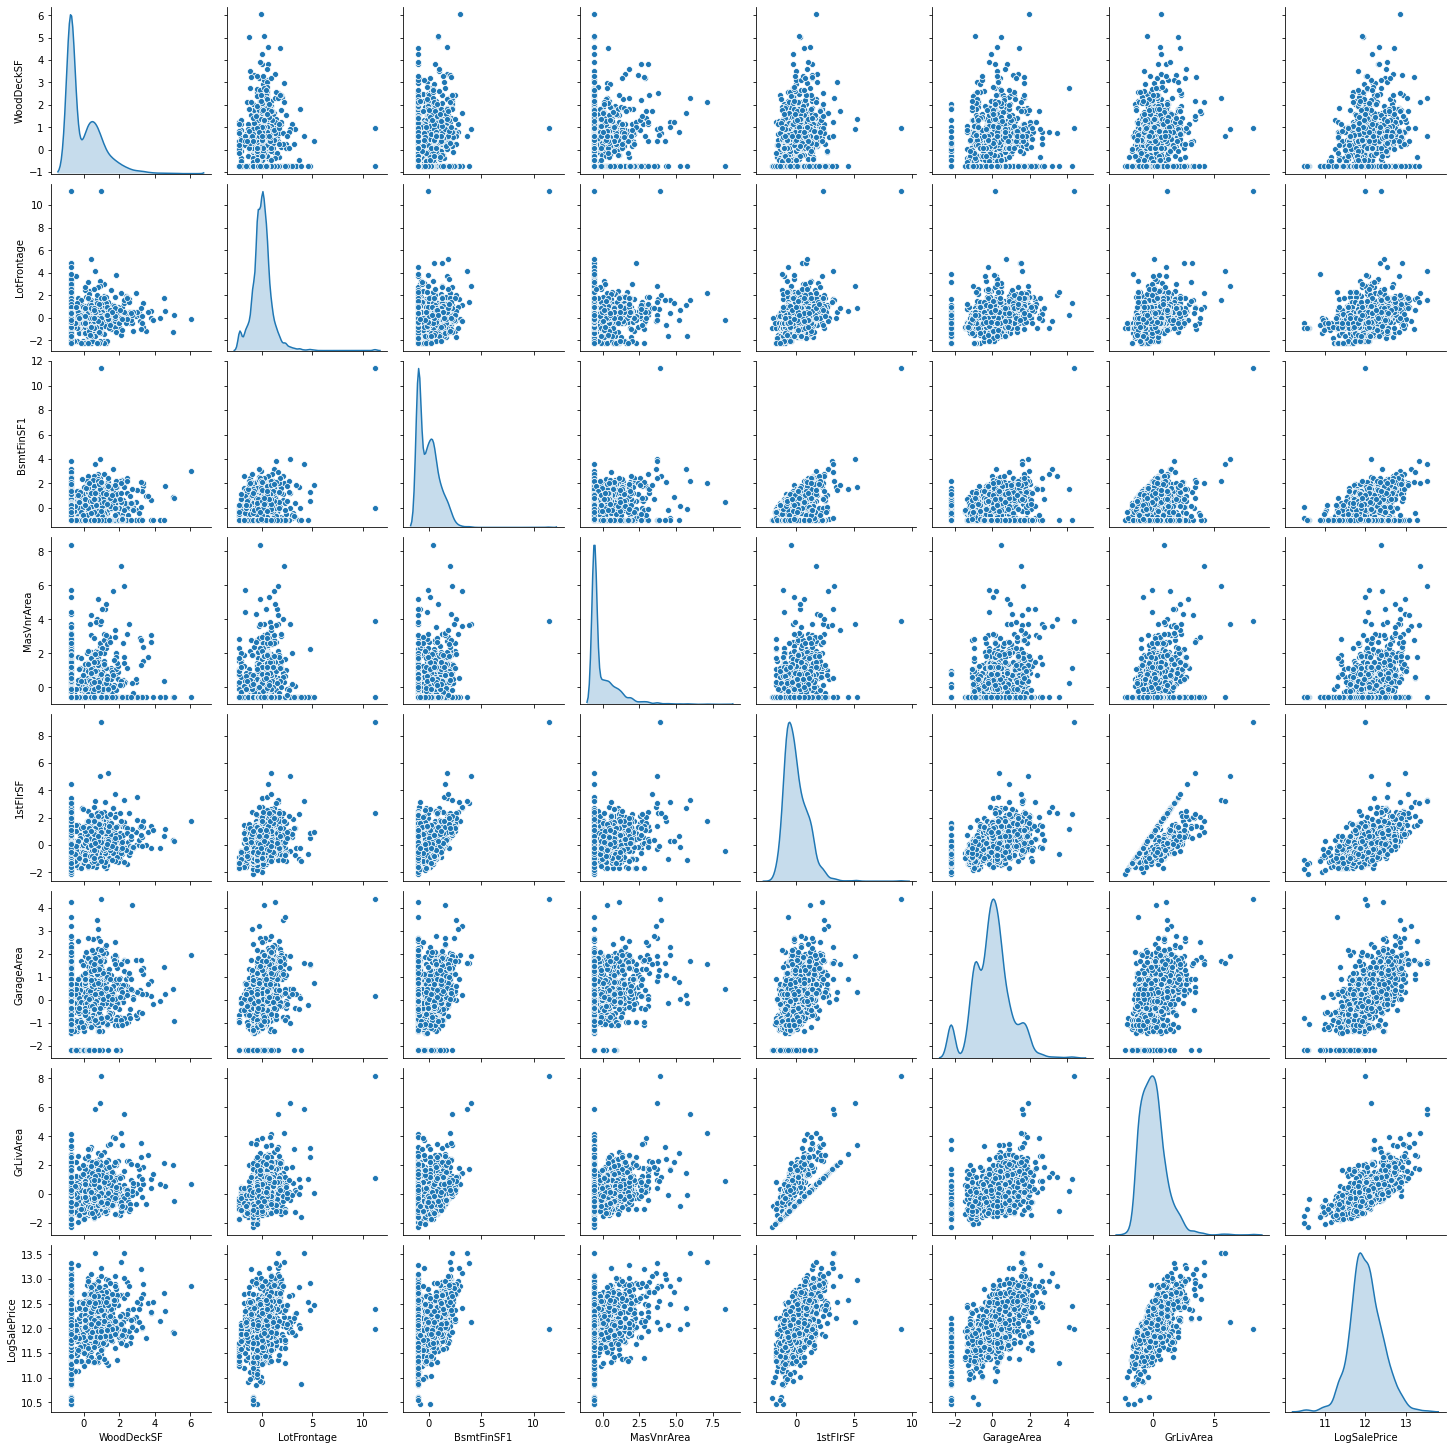

In [113]:
sns.pairplot(pd.concat([all_data.iloc[:1460,:], price['LogSalePrice']], axis=1)[list(cor.index[-8:])], diag_kind="kde")
plt.show()

In [114]:
train = all_data[:len(train_data)]
test = all_data[len(train_data):]

In [115]:
cat_feat = list(set(train.columns) - set(num_feat) - set(['Utilities', 'Id']))
print(len(cat_feat))
print(len(num_feat))

61
19


In [117]:
def log(x):
    if x > 0:
        result = np.log(x)
    else:
        result = x
    return result

log_num_feat = []
all_data_log = all_data.copy()
for feat in all_data[num_feat].columns:
    all_data_log['log_' + feat] = all_data[feat].apply(log)
    all_data_log.drop(feat, axis='columns', inplace=True)
    log_num_feat.append(feat)

In [118]:
pd.concat([all_data_log, price['LogSalePrice']], axis=1)

MSSubClass MSZoning Street Alley LotShape LandContour LotConfig  \
0            60       RL   Pave  None      Reg         Lvl    Inside   
1            20       RL   Pave  None      Reg         Lvl       FR2   
2            60       RL   Pave  None      IR1         Lvl    Inside   
3            70       RL   Pave  None      IR1         Lvl    Corner   
4            60       RL   Pave  None      IR1         Lvl       FR2   
...         ...      ...    ...   ...      ...         ...       ...   
2914        160       RM   Pave  None      Reg         Lvl    Inside   
2915        160       RM   Pave  None      Reg         Lvl    Inside   
2916         20       RL   Pave  None      Reg         Lvl    Inside   
2917         85       RL   Pave  None      Reg         Lvl    Inside   
2918         60       RL   Pave  None      Reg         Lvl    Inside   

     LandSlope Neighborhood Condition1  ... log_GarageArea log_WoodDeckSF  \
0          Gtl      CollgCr       Norm  ...      -1.051642      -0.740760   
1          Gtl      Veenker      Feedr  ...      -0.058991       0.479260   
2          Gtl      CollgCr       Norm  ...      -0.465554      -0.740760   
3          Gtl      Crawfor       Norm  ...      -0.241357      -0.740760   
4          Gtl      NoRidge       Norm  ...       0.522239      -0.252357   
...        ...          ...        ...  ...            ...            ...   
2914       Gtl      MeadowV       Norm  ...      -2.193574      -0.740760   
2915       Gtl      MeadowV       Norm  ...      -0.866421      -0.740760   
2916       Gtl      Mitchel       Norm  ...      -0.735440       1.100653   
2917       Gtl      Mitchel       Norm  ...      -2.193574      -0.108374   
2918       Mod      Mitchel       Norm  ...      -0.195183      -0.272915   

     log_OpenPorchSF log_EnclosedPorch log_3SsnPorch log_ScreenPorch  \
0          -1.609408         -0.359601     -0.103331       -0.285935   
1          -0.702843         -0.359601     -0.103331       -0.285935   
2          -0.081209         -0.359601     -0.103331       -0.285935   
3          -0.184815          1.354537     -0.103331       -0.285935   
4          -0.615401         -0.359601     -0.103331       -0.285935   
...              ...               ...           ...             ...   
2914       -0.702843         -0.359601     -0.103331       -0.285935   
2915       -0.347624         -0.359601     -0.103331       -0.285935   
2916       -0.702843         -0.359601     -0.103331       -0.285935   
2917       -0.229217         -0.359601     -0.103331       -0.285935   
2918       -4.880184         -0.359601     -0.103331       -0.285935   

     log_PoolArea log_TotalSF log_GreenArea LogSalePrice  
0        -0.06315   -3.772116     -0.259413    12.247694  
1        -0.06315   -0.029172     -0.041016    12.109011  
2        -0.06315   -1.624957     -2.457259    12.317167  
3        -0.06315   -0.092527     -0.130007    11.849398  
4        -0.06315   -0.011828     -0.934788    12.429216  
...           ...         ...           ...          ...  
2914     -0.06315   -1.129816     -0.952170          NaN  
2915     -0.06315   -1.129816     -0.994658          NaN  
2916     -0.06315   -0.123584      0.259322          NaN  
2917     -0.06315   -0.826704     -1.799788          NaN  
2918     -0.06315   -0.584874     -0.157728          NaN  

[2919 rows x 81 columns]

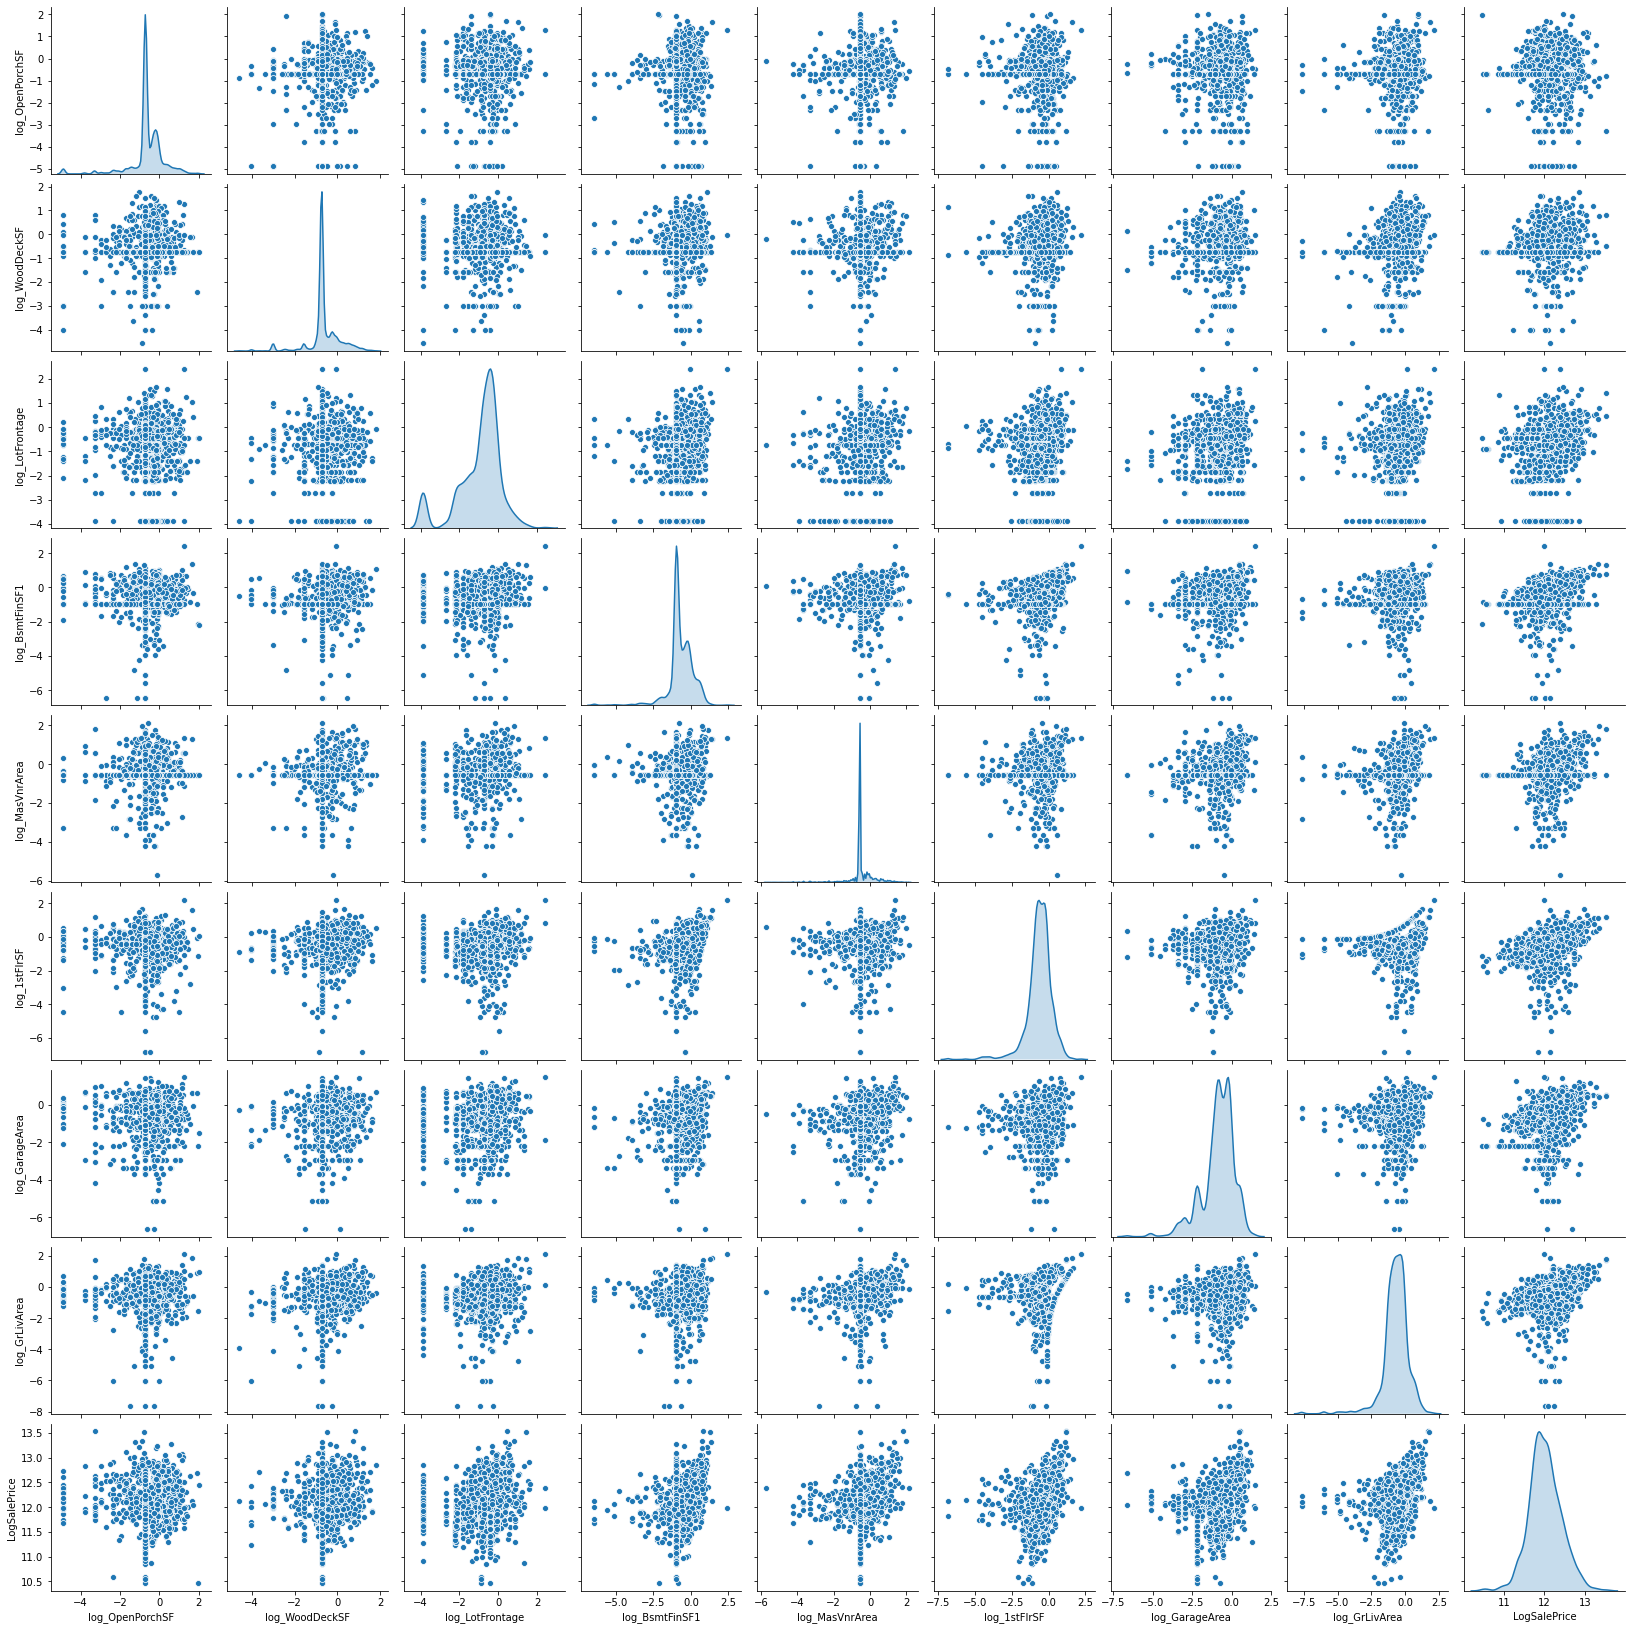

In [119]:
cor_index_log = []
for i in cor.index:
    if i != 'LogSalePrice':
        cor_index_log.append('log_' + i)

sns.pairplot(pd.concat([all_data_log.iloc[:1460,:], price['LogSalePrice']], axis=1)[list(cor_index_log[-8:] + ['LogSalePrice'])], diag_kind="kde")
plt.show()

In [178]:
log_train = all_data_log[:len(train_data)]
log_test = all_data_log[len(train_data):]

In [170]:
train_log = pd.concat([all_data_log.iloc[:1460,:], price['LogSalePrice']], axis=1)

outlier_ids = set()
# outlier_ids = outlier_ids.union(set(log_train[log_train.log_LotArea > 60000].index.values))
# outlier_ids = outlier_ids.union(set(log_train[log_train.log_LotFrontage > 200].index.values))
# outlier_ids = outlier_ids.union(set(log_train[(log_train.log_LotFrontage > 150) & (log_train.SalePrice.apply(np.log) < 11)].index.values))
# outlier_ids = outlier_ids.union(set(log_train[log_train.log_GrLivArea > 4500].index.values))
# outlier_ids = outlier_ids.union(set(log_train[log_train["log_1stFlrSF"] > 4000].index.values))
outlier_ids = outlier_ids.union(set(train_log[train_log.log_MasVnrArea < -5].index.values))
# outlier_ids = outlier_ids.union(set(log_train[log_train["log_BsmtFinSF1"] > 5000].index.values))
# outlier_ids = outlier_ids.union(set(log_train[log_train.log_TotalBsmtSF > 6000].index.values))
outlier_ids = outlier_ids.union(set(train_log[(train_log.log_OpenPorchSF > 1) & (train_log.LogSalePrice < 11)].index.values))
outlier_ids = outlier_ids.union(set(train_log[(train_log.log_OpenPorchSF < -2) & (train_log.LogSalePrice < 11)].index.values))
outlier_ids = outlier_ids.union(set(train_log[(train_log.log_OpenPorchSF < -2) & (train_log.LogSalePrice > 13)].index.values))

In [171]:
outlier_ids

{30, 245, 495, 691}

In [179]:
log_train = log_train.drop(list(outlier_ids))
price = price.drop(list(outlier_ids))

In [175]:
len(log_train)

1456

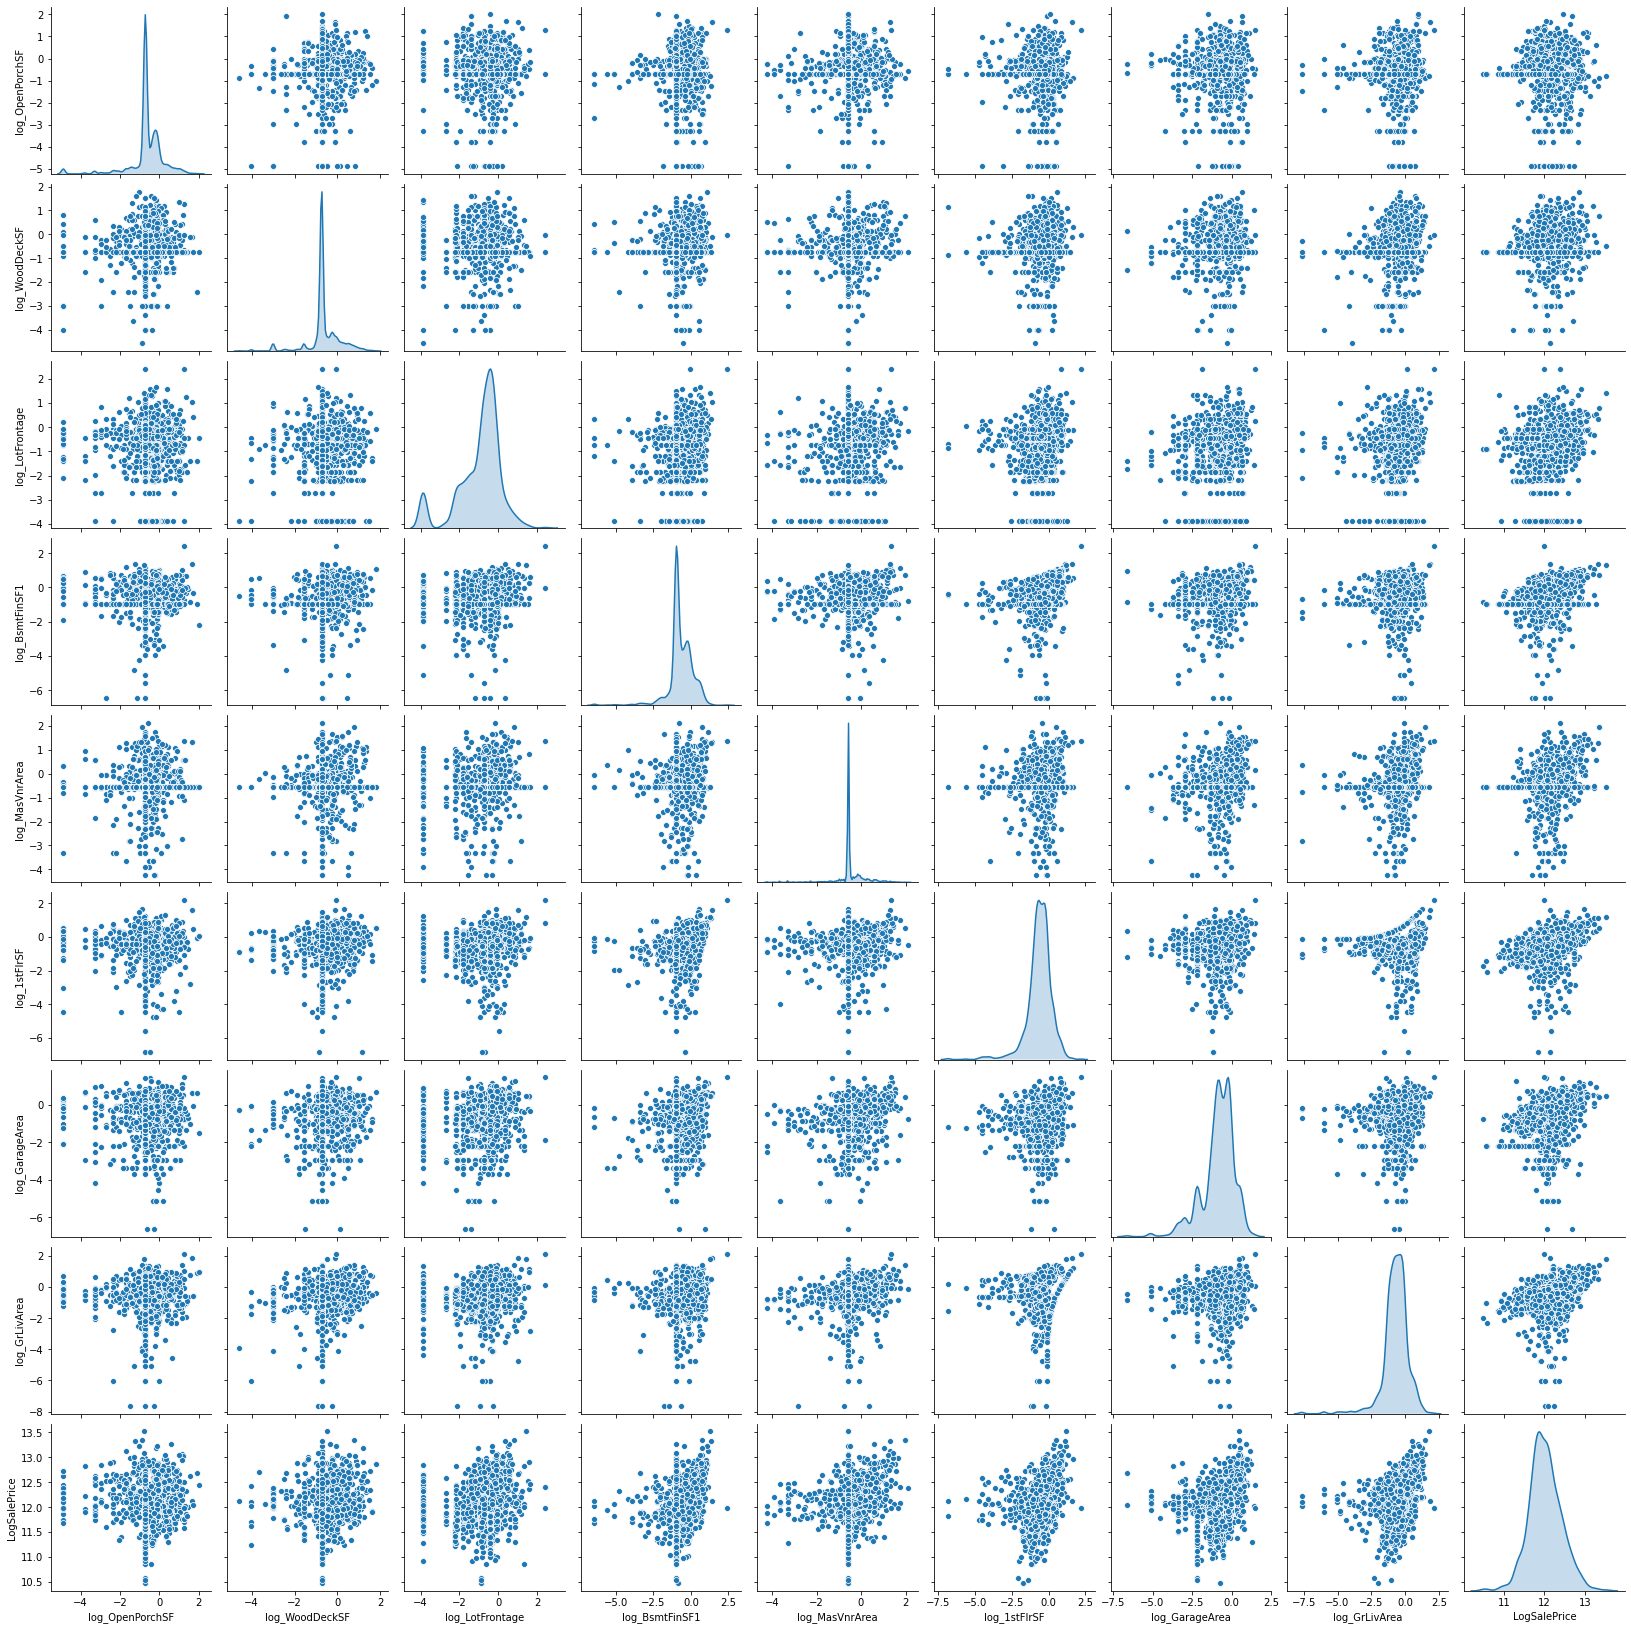

In [176]:
sns.pairplot(pd.concat([log_train, price['LogSalePrice']], axis=1)[list(cor_index_log[-8:] + ['LogSalePrice'])], diag_kind="kde")
plt.show()

In [28]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [177]:
import catboost as ct

In [187]:
X_train, X_valid, y_train, y_valid = train_test_split(log_train, price['LogSalePrice'], train_size=0.8, random_state=13)

In [188]:
cat_model = ct.CatBoostRegressor(iterations = 2000, learning_rate = 0.1, early_stopping_rounds = 250)

cat_model.fit(
    X_train, y_train,
    cat_features=cat_feat,
    eval_set = (X_valid, y_valid),
    verbose = 100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3529871	test: 0.3774215	best: 0.3774215 (0)	total: 99.3ms	remaining: 3m 18s
100:	learn: 0.0879033	test: 0.1477687	best: 0.1477469 (99)	total: 5.5s	remaining: 1m 43s
200:	learn: 0.0635964	test: 0.1446266	best: 0.1443825 (192)	total: 12.2s	remaining: 1m 48s
300:	learn: 0.0505068	test: 0.1434259	best: 0.1432517 (267)	total: 18s	remaining: 1m 41s
400:	learn: 0.0408060	test: 0.1434965	best: 0.1432517 (267)	total: 24s	remaining: 1m 35s
500:	learn: 0.0342694	test: 0.1433854	best: 0.1430057 (422)	total: 30.5s	remaining: 1m 31s
600:	learn: 0.0295332	test: 0.1429420	best: 0.1428887 (587)	total: 37.5s	remaining: 1m 27s
700:	learn: 0.0254283	test: 0.1426119	best: 0.1425596 (696)	total: 44.9s	remaining: 1m 23s
800:	learn: 0.0220627	test: 0.1424702	best: 0.1422130 (750)	total: 51.5s	remaining: 1m 17s
900:	learn: 0.0191451	test: 0.1425883	best: 0.1422130 (750)	total: 57.5s	remaining: 1m 10s
1000:	learn: 0.0166305	test: 0.1425067	best: 0.1422130 (750)	total: 1m 4s	remaining: 1m 3s
1100:	le

In [189]:
cat_model.get_feature_importance(prettified=True)

Feature Id  Importances
0        OverallQual    13.951241
1        log_TotalSF     9.841539
2       Neighborhood     4.607503
3         GarageCars     4.344174
4      log_GrLivArea     3.436148
..               ...          ...
75          RoofMatl     0.045592
76    log_BsmtFinSF2     0.040261
77       MiscFeature     0.031202
78  log_LowQualFinSF     0.005930
79            Street     0.003544

[80 rows x 2 columns]

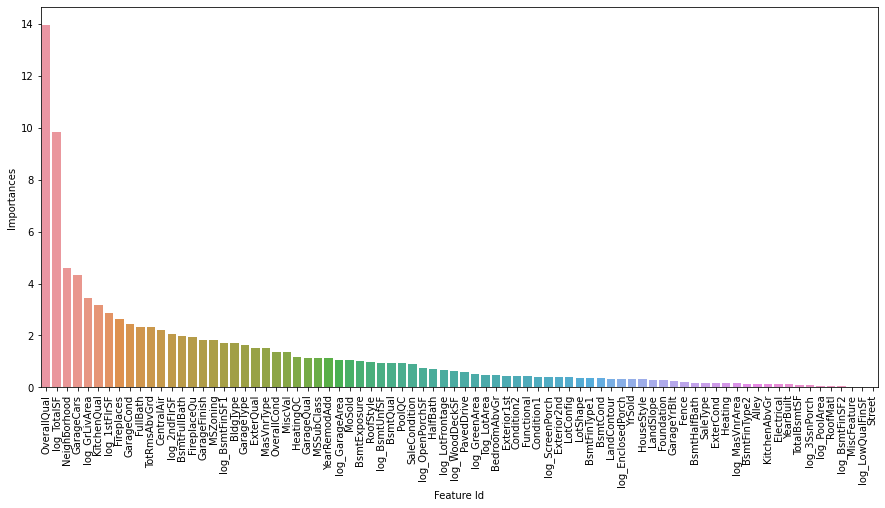

In [190]:
f, ax = plt.subplots(figsize=(15, 7))
plt.xticks(rotation='90')
sns.barplot(x=cat_model.get_feature_importance(prettified=True)['Feature Id'], y=cat_model.get_feature_importance(prettified=True)['Importances'])

In [191]:
to_drop = cat_model.get_feature_importance(prettified=True)['Feature Id'][-5:]
log_train = log_train.drop(to_drop, axis=1)
log_test = log_test.drop(to_drop, axis=1)

In [192]:
for drop_feat in cat_model.get_feature_importance(prettified=True)['Feature Id'][-5:]:
    for i, feat in enumerate(cat_feat):
        if feat == drop_feat:
            cat_feat.pop(i)    

In [193]:
X_train, X_valid, y_train, y_valid = train_test_split(log_train, price['LogSalePrice'], train_size=0.7, random_state=223)

In [194]:
from hyperopt import tpe, hp, fmin, Trials

In [223]:
def catboost_cv_score(params):
    cv_data = ct.cv(
        params = params,
        pool = ct.Pool(log_train, label=price['LogSalePrice'], cat_features=cat_feat),
        fold_count = 4,
        shuffle = True,
        partition_random_seed = 1,
        plot=True,
        verbose = 200
  )
    best_value = np.min(cv_data['test-RMSE-mean'])
    return(best_value)

In [220]:
space_catboost = {
            'l2_leaf_reg': hp.choice('l2_leaf_reg', [0, 0.5]),
            'bagging_temperature': hp.choice('bagging_temperature', [12, 17, 22, 26, 30]),
            'depth':  hp.choice('depth', [3, 6, 10]),
            'random_strength': hp.choice('random_strength', [0, 0.5]),
            #'border_count': hp.choice('border_count', [128, 254]),
            #'grow_policy': hp.choice('grow_policy', ['Depthwise']),
            'eval_metric': 'RMSE',
            #'feature_border_type': hp.choice('feature_border_type', ['MaxLogSum']), 
            'leaf_estimation_method': hp.choice('leaf_estimation_method', ['Newton']),
            'task_type': 'GPU',
            'loss_function': 'RMSE',
            'custom_metric':'RMSE',
            'random_seed': 1338,
            'learning_rate': 0.08,
            'iterations': 7000,
            'early_stopping_rounds': 500
        }

In [227]:
trials = Trials()

In [228]:
best = fmin(
    fn=catboost_cv_score, 
    space=space_catboost, 
    algo=tpe.suggest, 
    max_evals=20,
    trials=trials
  )

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 11.0705739	test: 11.0692128	best: 11.0692128 (0)

200:	learn: 0.1661844	test: 0.2322515	best: 0.2322515 (200)

400:	learn: 0.1485853	test: 0.2236922	best: 0.2233191 (351)

600:	learn: 0.1430775	test: 0.2209942	best: 0.2209794 (567)

800:	learn: 0.1372652	test: 0.2176352	best: 0.2176352 (800)

1000:	learn: 0.1347635	test: 0.2171368	best: 0.2171317 (996)

1200:	learn: 0.1295202	test: 0.2150806	best: 0.2150394 (1197)

1400:	learn: 0.1268009	test: 0.2139301	best: 0.2139011 (1390)

1600:	learn: 0.1244024	test: 0.2134029	best: 0.2134029 (1600)

1800:	learn: 0.1216895	test: 0.2125789	best: 0.2125692 (1795)

2000:	learn: 0.1207462	test: 0.2122709	best: 0.2122709 (2000)

2200:	learn: 0.1199711	test: 0.2121777	best: 0.2120682 (2117)

2400:	learn: 0.1182057	test: 0.2116490	best: 0.2116316 (2390)	total: 11m 9s	remaining: 21m 21s

  0%|          | 0/20 [12:56<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [203]:
import hyperopt
params_opt = hyperopt.space_eval(space_catboost, best)
# {'bagging_temperature': 17,
#  'custom_metric': 'RMSE',
#  'depth': 3,
#  'early_stopping_rounds': 500,
#  'eval_metric': 'RMSE',
#  'feature_border_type': 'MaxLogSum',
#  'grow_policy': 'Depthwise',
#  'iterations': 7000,
#  'l2_leaf_reg': 0,
#  'leaf_estimation_method': 'Newton',
#  'learning_rate': 0.08,
#  'loss_function': 'RMSE',
#  'random_seed': 1338,
#  'random_strength': 0,
#  'task_type': 'GPU'}
params_opt

{'bagging_temperature': 17,
 'custom_metric': 'RMSE',
 'depth': 3,
 'early_stopping_rounds': 500,
 'eval_metric': 'RMSE',
 'feature_border_type': 'MaxLogSum',
 'grow_policy': 'Depthwise',
 'iterations': 7000,
 'l2_leaf_reg': 0,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.08,
 'loss_function': 'RMSE',
 'random_seed': 1338,
 'random_strength': 0,
 'task_type': 'GPU'}

In [212]:
params_opt['learning_rate'] = 0.004
params_opt['iterations'] = 32500
params_opt['random_seed'] = 1337
params_opt['early_stopping_rounds'] = 20000
params_opt['loss_function'] = 'RMSE'
params_opt['eval_metric'] = 'RMSE'

In [ ]:
params = {}
params['learning_rate'] = 0.1
params['iterations'] = 2000
params['random_seed'] = 1337
params['loss_function'] = 'RMSE'
params['early_stopping_rounds'] = 500
params['eval_metric'] = 'RMSE'
# params['l2_leaf_reg'] = 3
# params['bagging_temperature'] = 1
# params['random_strength'] = 1
# params['leaf_estimation_method'] = 'Newton'
# params['snapshot_file'] = 'snapshot.bkp'
# params['snapshot_interval'] = 10
# params['per_float_feature_quantization'] = ['0:border_count=1024', '1:border_count=1024', '2:border_count=1024', '3:border_count=1024', '4:border_count=1024', '5:border_count=1024'] 
# params['task_type'] = 'GPU'
# #params['depth'] = 6
# params['class_weights'] = [1.9, 0.6]
# params['feature_border_type'] = 'MaxLogSum'

In [211]:
X_train, X_valid, y_train, y_valid = train_test_split(log_train, price['LogSalePrice'], train_size=1, random_state=220)

In [214]:
cat_model = ct.CatBoostRegressor(**params_opt)

cat_model.fit(
    log_train, price['LogSalePrice'],
    cat_features=cat_feat,
    #eval_set = (X_valid, y_valid),
    verbose = 1000,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3933180	total: 13.6ms	remaining: 7m 21s
1000:	learn: 0.1695891	total: 6.86s	remaining: 3m 35s
2000:	learn: 0.1435303	total: 13.8s	remaining: 3m 30s
3000:	learn: 0.1334868	total: 20.7s	remaining: 3m 23s
4000:	learn: 0.1268143	total: 30.1s	remaining: 3m 34s
5000:	learn: 0.1216623	total: 37.6s	remaining: 3m 26s
6000:	learn: 0.1172589	total: 45.1s	remaining: 3m 19s
7000:	learn: 0.1135692	total: 53.6s	remaining: 3m 15s
8000:	learn: 0.1102231	total: 1m 1s	remaining: 3m 9s
9000:	learn: 0.1071185	total: 1m 9s	remaining: 3m 1s
10000:	learn: 0.1042587	total: 1m 20s	remaining: 3m
11000:	learn: 0.1016358	total: 1m 28s	remaining: 2m 52s
12000:	learn: 0.0992390	total: 1m 36s	remaining: 2m 44s
13000:	learn: 0.0969587	total: 1m 45s	remaining: 2m 38s
14000:	learn: 0.0947867	total: 1m 55s	remaining: 2m 32s
15000:	learn: 0.0927556	total: 2m 6s	remaining: 2m 27s
16000:	learn: 0.0908071	total: 2m 15s	remaining: 2m 19s
17000:	learn: 0.0889765	total: 2m 25s	remaining: 2m 12s
18000:	learn: 0.08724

In [215]:
pred = pd.DataFrame({'SalePrice':cat_model.predict(log_test)})

In [216]:
ans = pd.concat([test_data['Id'], pred], axis=1)

In [217]:
ans['SalePrice'] = ans['SalePrice'].apply(np.exp)
ans

Id      SalePrice
0     1461  120925.201859
1     1462  150157.195956
2     1463  169578.559357
3     1464  206918.558272
4     1465  183337.502871
...    ...            ...
1454  2915   84684.316026
1455  2916   88461.711461
1456  2917  169198.321966
1457  2918  128273.133333
1458  2919  206046.375761

[1459 rows x 2 columns]

In [219]:
ans.to_csv('ans6.csv', index=False)

In [ ]:
ans_path = "/content/drive/My Drive/Colab Notebooks/prices/ans4.csv"

In [ ]:
ans.to_csv(ans_path, sep = ',', index=False)